# Data Preprocessing

Tasks
1.   Load Kaggle traffic sign data from drive
2.   Unpickle files
3.   Filter out classes not related to speed
4.   Normalize number of samples per class
5.   Split into train / val / test sets
6.   Shuffle datasets
7.   Resize
8.   Normalize pixel values
9.   Make pytorch dataloaders

In [1]:
import pickle
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
# Data directory
# Change this as needed
data_dir = '/content/gdrive/My Drive/APS360 Project/'

In [13]:
# Data loaders

def get_data_loader(batch_size):
    ''' The Kaggle dataset is split into three pickle files: train.pickle,
    valid.pickle, and test.pickle.
    The function will combine the three datasets and resplit them such that the
    resulting split is approximately 70% training, 15% validation, and 15% testing.
    The function filters classes 0-8 only, as they are related to speed.
    The splitting ratio will be applied to each class, to avoid imbalance of 
    classes in the training/validation/testing samples.'''

    classes = ('Speed limit (20km/h)',
            'Speed limit (30km/h)',
            'Speed limit (50km/h)',
            'Speed limit (60km/h)',
            'Speed limit (70km/h)',
            'Speed limit (80km/h)',
            'End of speed limit (80km/h)',
            'Speed limit (100km/h)',
            'Speed limit (120km/h)')

    # load pickle files
    # will combine datasets from three seperate pikcle files
    
    with open(data_dir+'train.pickle', 'rb') as file:
        data1 = pickle.load(file)

    with open(data_dir+'valid.pickle', 'rb') as file:
        data2 = pickle.load(file)

    with open (data_dir+'test.pickle', 'rb') as file:
        data3 = pickle.load(file)

    images = np.concatenate((data1['features'], data2['features'], data3['features']))
    labels = np.concatenate((data1['labels'], data2['labels'], data3['labels']))
    
    # sort into classes
    class_images = []
    class_labels = []
    for i in range(9):
        class_indices = np.where(labels==i)
        #print(i, 'has', len(class_indices[0]), 'elements') # check number of samples for each class
        class_images.append(images[class_indices])
        class_labels.append(labels[class_indices])

    # normalize number of samples in each class
    desired_size=3000
    extra_samples = []
    extra_labels = []
    for i in range(9):
        # Randomly sample from the original class images to duplicate to extra
        # Duplicate enough samples to make the total for the class 3000
        extra_samples.append(
            class_images[i][np.random.randint(
                low=0,
                high=class_images[i].shape[0],
                size=desired_size-class_images[i].shape[0])])
        # Add random noise to create variation from originals
        noise = np.random.normal(0,1, extra_samples[i].size)
        noise = noise.reshape(extra_samples[i].shape[0],extra_samples[i].shape[1],extra_samples[i].shape[2],extra_samples[i].shape[3]).astype('uint8')
        extra_samples[i] = extra_samples[i]+noise

        # add labels for extra samples
        extra_labels.append(np.full(extra_samples[i].shape[0], i))

        # append to original
        class_images[i] = np.concatenate((class_images[i],extra_samples[i]))
        class_labels[i] = np.concatenate((class_labels[i],extra_labels[i]))

    # split into train /  val / test
    train_split = 0.7
    val_split = 0.85

    train_image_arrays = [class_images[i][0:int(train_split*class_images[i].shape[0])] for i in range(9)]
    train_label_arrays = [class_labels[i][0:int(train_split*class_images[i].shape[0])] for i in range(9)]
    train_images = np.concatenate(train_image_arrays)
    train_labels = np.concatenate(train_label_arrays)

    val_image_arrays = [class_images[i][int(train_split*class_images[i].shape[0]):int(val_split*class_images[i].shape[0])] for i in range(9)]
    val_label_arrays = [class_labels[i][int(train_split*class_images[i].shape[0]):int(val_split*class_images[i].shape[0])] for i in range(9)]
    val_images = np.concatenate(val_image_arrays)
    val_labels = np.concatenate(val_label_arrays)

    test_image_arrays = [class_images[i][int(val_split*class_images[i].shape[0]):] for i in range(9)]
    test_label_arrays = [class_labels[i][int(val_split*class_images[i].shape[0]):] for i in range(9)]
    test_images = np.concatenate(test_image_arrays)
    test_labels = np.concatenate(test_label_arrays)

    # shuffle
    np.random.seed(9001)
    indices = list(range(train_images.shape[0]))
    np.random.shuffle(indices)
    train_images = train_images[indices]
    train_labels = train_labels[indices]
    
    indices = list(range(val_images.shape[0]))
    np.random.shuffle(indices)
    val_images = val_images[indices]
    val_labels = val_labels[indices]
   
    indices = list(range(test_images.shape[0]))
    np.random.shuffle(indices)
    test_images = test_images[indices]
    test_labels = test_labels[indices]

    # make into torch datasets
    train_image_tensor = torch.Tensor(train_images.transpose(0,3,1,2))
    train_label_tensor = torch.Tensor(train_labels)
    
    val_image_tensor = torch.Tensor(val_images.transpose(0,3,1,2))
    val_label_tensor = torch.Tensor(val_labels)
    
    test_image_tensor = torch.Tensor(test_images.transpose(0,3,1,2))
    test_label_tensor = torch.Tensor(test_labels)
   
    trainset = TensorDataset(train_image_tensor, train_label_tensor)
    valset = TensorDataset(val_image_tensor, val_label_tensor)
    testset = TensorDataset(test_image_tensor, test_label_tensor)

    # resize and normalization
    transform = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    #trainset.transform = transform
    #valset.transform = transform
    #testset.transform = transform

    # make data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        num_workers=1)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        num_workers=1)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        num_workers=1)
    
    return train_loader, val_loader, test_loader, classes 

In [15]:
batch_size = 32
train_loader, val_loader, test_loader, classes = get_data_loader (batch_size)
print (classes)
print (len(train_loader))
print (len(val_loader))
print (len(test_loader))

('Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)')
591
127
127


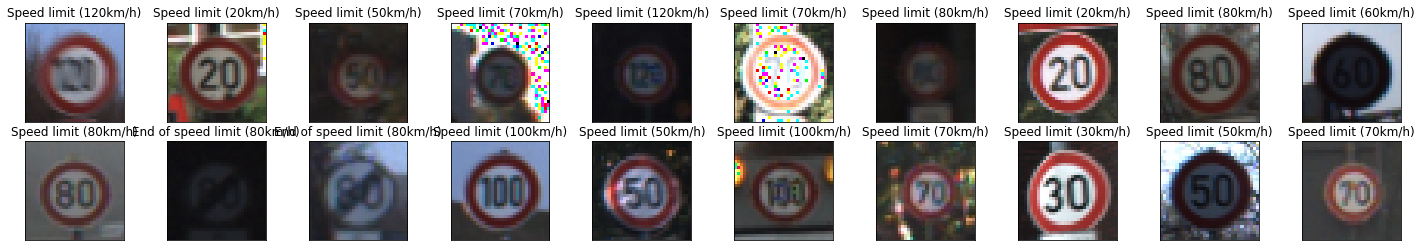

In [16]:
# Check one batch
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy().astype(int) # convert images to numpy for display
labels = labels.int()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
# close all figures to prevent memory leak
plt.close('all')